# Measuring growth rates in _Cannabis Sativa_ using infrared computer vision: a study

## Authors: C. Webb, B. Bugbee

### Abstract

In this paper, we will explore our findings in using computer vision to study the growth rate of Cannabis, specifically as it applies to assisting academic research in other areas. We will give an overview of the analytical algorithm we developed, briefly cover the other algorithms we considered, and give an analysis of the accuracy of this system.

### Overview of the GPEureka Algorithm

The GPEureka algorithm is a computer vision algorithm, tuned specifically to work with images taken of _Cannabis Sativa_ in small greenhouse chambers. The current implementation is built around a chamber 45cm wide by 60cm deep by 100cm tall, lit from above with highly reflective walls. The pictures are taken using a Raspberry Pi microcomputer, hooked up to a Raspberry Pi Camera Module 2 NoIR with a 850nm infrared cutoff filter (currently a Schott RG9). This setup allows us to work in a wavelength band that will not cause flowering issues in Cannabis, and allows us to take advantage of the highly reflective nature of Cannabis leaves under infrared lighting.

The algorithm itself is fairly simple. By taking pictures every hour on the hour, and comparing pictures taken 24 hours apart, we can eliminate any problems resulting from time-of-day variations in the state of the plants. This also allows us to output a growth rate value for the prior 24 hours every hour.

This algorithm is dependent upon [Pillow](https://pillow.readthedocs.io/en/stable/) and [Numpy](https://numpy.org/). In this notebook, we will also use [Matplotlib](https://matplotlib.org/) to show the images generated by each step of the algorithm.

We begin by taking the two pictures, one referred to as "start" and taken at 9:00 AM on the 14th of July, and the other referred to as "end" and taken at 9:00 AM on the 15th of July, and opening and cropping them both:

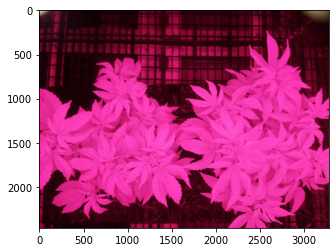

In [9]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from matplotlib import pyplot
%matplotlib inline

def countingSequence(n):
    toReturn = []
    for i in range(n):
        toReturn.append(i + 1)
    return toReturn

def plot(data, title="Arbitrary Graph", xAxis="x", yAxis="y", save=False, loc="./fig.png", scatter=False):
    sequence = countingSequence(len(data))
    if scatter:
        pyplot.scatter(sequence, data)
    else:
        pyplot.plot(sequence, data)
    pyplot.xlabel(xAxis)
    pyplot.ylabel(yAxis)
    pyplot.title(title)
    dataMin = min(data)
    dataMax = max(data)
    if dataMin > 0:
        pyplot.ylim(bottom=0, top=(1.2 * dataMax))
    if save:
        pyplot.savefig(loc)
        pyplot.cla()

start = "./9-28-2021 16_0.png"
end = "./9-29-2021 16_0.png"
start_pillow = Image.open(start)
end_pillow = Image.open(end)
start_numpy = np.array(start_pillow)
end_numpy = np.array(end_pillow)
imshow(start_numpy)

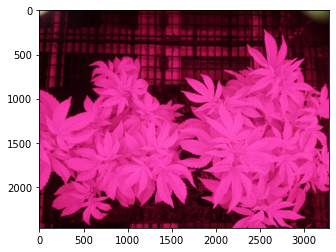

In [10]:
imshow(end_numpy)

From here, we can then threshold the image, effectively converting any pixel above a certain brightness into a white pixel and any pixel below that brightness into a black pixel. Through some experimentation, we settled upon 110 as an appropriate brightness threshold.

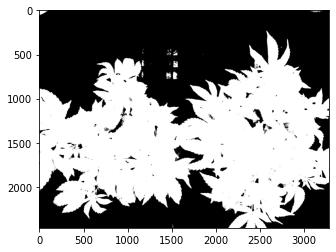

In [11]:
for i in start_numpy:
    for j in i:
        if (int(j[0]) + int(j[1]) + int(j[2]))/3 > 110:
            j[0] = 255
            j[1] = 255
            j[2] = 255
        else:
            j[0] = 0
            j[1] = 0
            j[2] = 0

for i in end_numpy:
    for j in i:
        if (int(j[0]) + int(j[1]) + int(j[2]))/3 > 110:
            j[0] = 255
            j[1] = 255
            j[2] = 255
        else:
            j[0] = 0
            j[1] = 0
            j[2] = 0

imshow(start_numpy)

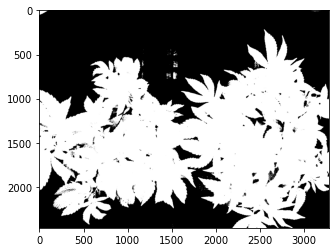

In [12]:
imshow(end_numpy)

From here, it is fairly straightforward to count the number of white pixels in both images, and conclude that any increase in white pixel counts correlates to new plant growth in the 24 hours between images.

In [13]:
start_white_pixels = 0
end_white_pixels = 0
for i in start_numpy:
    for j in i:
        if j[0] == 255:
            start_white_pixels += 1
for i in end_numpy:
    for j in i:
        if j[0] == 255:
            end_white_pixels += 1
percent_change = ((float(end_white_pixels)/start_white_pixels) - 1) * 100
print("Starting white pixels: " + str(start_white_pixels))
print("Ending white pixels: " + str(end_white_pixels))
print("Pixel count delta: " + str(end_white_pixels - start_white_pixels))
print("Percent change: " + str(percent_change))

Starting white pixels: 4123093
Ending white pixels: 4306643
Pixel count delta: 183550
Percent change: 4.4517550295372965


We can also use the relative growth rate equation to gain some valuable data.

$$\frac{ln (\frac{m_2}{m_1})}{\Delta t}$$

In [14]:
rgr_daily = np.log(float(end_white_pixels)/start_white_pixels)/1
rgr_hourly = np.log(float(end_white_pixels)/start_white_pixels)/24
print("RGR Daily: " + str(rgr_daily * 100)[:6] + "%")
print("RGR Hourly: " + str(rgr_hourly * 100)[:6] + "%")

RGR Daily: 4.3555%
RGR Hourly: 0.1814%


### Overview of the Otsureka algorithm, a variant of GPEureka

The Otsureka algorithm functions very similarly to the GPEureka algorithm, with one notable exception: where GPEureka uses a static threshold, chosen at the beginning and adjusted as necessary throughout usage, Otsureka uses Otsu's Binarization to generate an adaptive threshold each hour. This has, in early studies, been comparable to the original algorithm without needing frequent retuning.

In all other aspects, Otsureka is identical to its sibling, GPEureka. There are some tooling changes; configuration of cropping has moved to a dedicated JSON file instead of being hardcoded, external processes are run with ```subprocess.run``` instead of ```os.system```, moving from Numpy and Pillow to less Numpy and OpenCV, and a few other optimizations.

In the first trial of the Otsureka algorithm, we recorded the watering times of the plants in question. The data from the trial is shown below, including red vertical lines showing when watering occurred. The one purple line shows when a leaf at the top of the canopy was removed as part of the experiment.

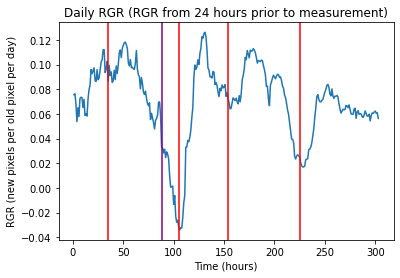

In [15]:
startOfData = 7
data = pd.read_csv("./data.csv",delimiter=",", header=0)
plot(data['Daily RGR'][startOfData:len(data)], 
    title="Daily RGR (RGR from 24 hours prior to measurement)",
    xAxis="Time (hours)",
    yAxis="RGR (new pixels per old pixel per day)")
pyplot.axvline(x=42 - startOfData, color="red")
pyplot.axvline(x=112 - startOfData, color="red")
pyplot.axvline(x=161 - startOfData, color="red")
pyplot.axvline(x=232 - startOfData, color="red")
pyplot.axvline(x=95 - startOfData, color="purple")

As can be seen from this data, it is straightforward to correlate watering with an increase of plant growth. This is not news to anyone, but it shows that this algorithm can accurately show when a plant is under stress.